In [1]:
from utils_DS_luis import history_treatment
# from utils_DS_luis import transform_data
# from utils_DS_luis import plot_correlation

import tensorflow as tf 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pickle import dump, load 

### Reading, treating, and exploring data

In [278]:
file = 'new_database_slopes.txt'
data = pd.read_csv(file)
data.columns = ['Model', 'h(m)','Inclination', 'Cohesion',
                'Friction_angle', 'Specific_weight','Safety_factor']
data.drop('Model', axis=1, inplace=True)
data = data[data['Safety_factor'] < 10]
data['Safety_factor'] = np.log(data['Safety_factor'])
data.head()

,h(m),Inclination,Cohesion,Friction_angle,Specific_weight,Safety_factor
0,44.273,23.6725,285.45,44.375,19.23,1.747443
1,23.681,40.9425,234.15,23.425,15.55,1.682936
2,74.765,17.9525,151.05,43.825,17.01,1.552003
3,48.035,24.4975,52.65,19.475,23.91,0.327102
4,197.525,27.5775,205.65,4.925,11.45,-0.101676


In [279]:
data.describe()

,h(m),Inclination,Cohesion,Friction_angle,Specific_weight,Safety_factor
count,956.000000,956.000000,956.000000,956.000000,956.000000,956.000000
mean,104.789753,32.800486,147.094142,24.712814,20.035690,0.590890
std,55.432174,15.613362,86.396611,14.403193,5.811989,0.832208
min,2.693000,5.082500,0.150000,0.025000,10.010000,-3.187501
25%,57.489500,19.423750,72.375000,12.312500,14.965000,0.038078
50%,105.158000,32.775000,145.800000,24.450000,20.100000,0.583972
75%,152.628500,46.291250,221.025000,37.137500,25.115000,1.180226
max,199.901000,59.972500,299.850000,49.975000,29.990000,2.296304


<AxesSubplot: xlabel='Safety_factor', ylabel='Count'>

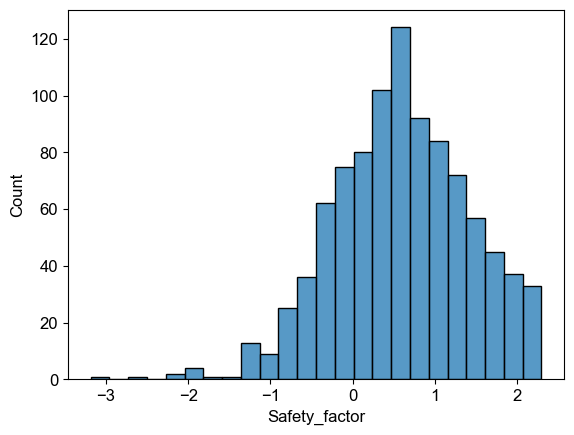

In [281]:
sns.histplot(data=data, x='Safety_factor')

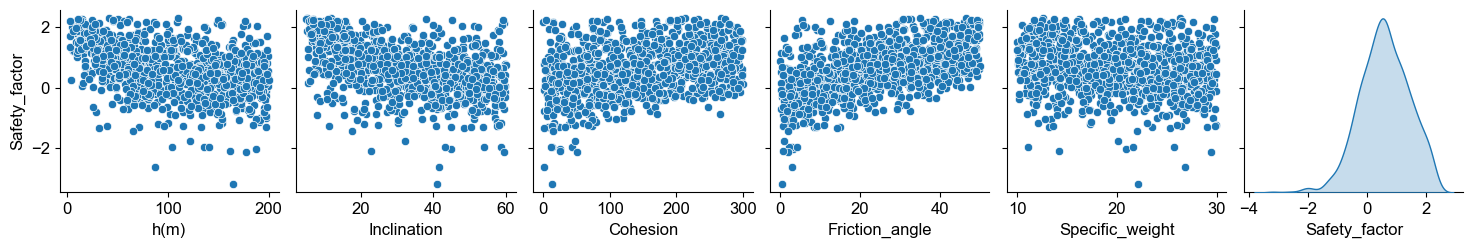

In [282]:
sns.pairplot(data=data[data['Safety_factor'] < 10], 
             diag_kind="kde", y_vars='Safety_factor')


<AxesSubplot: >

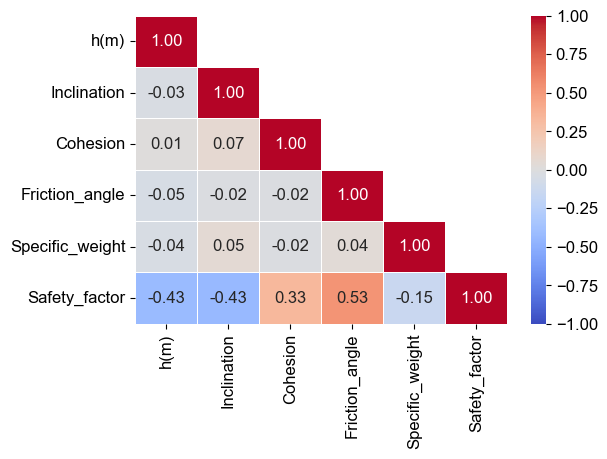

In [283]:
correlation = data.corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(6,4))
plot = sns.heatmap(correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
                   annot = True, fmt=".2f", linewidths=.6)
plt.xticks(rotation = 90)
plot

In [284]:
inp_columns = ['h(m)', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight']
out_column = ['Safety_factor']

# Scalers:
inp_scaler = StandardScaler()
inp_scaler.fit(data[inp_columns])
out_scaler = StandardScaler()
out_scaler.fit(data[out_column])

x_norm = inp_scaler.transform(data[inp_columns])
y_norm = out_scaler.transform(data[out_column])

x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size = 0.3,
                                                    random_state = 0)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5,
                                                random_state=0)

In [285]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)


(669, 5)
(669, 1)
(143, 5)
(143, 1)
(144, 5)
(144, 1)


In [194]:
dump(inp_scaler, open('input_scaler.save', 'wb'))
dump(out_scaler, open('output_scaler.save', 'wb'))

In [195]:
def create_model(learning_rate, num_dense_layers, num_dense_nodes, activation): 

    model = tf.keras.models.Sequential()    
    model.add(tf.keras.layers.Dense(num_dense_nodes, input_dim=x_train.shape[1]))


    for i in range(num_dense_layers-1):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(tf.keras.layers.Dense(num_dense_nodes,
                                        activation=activation,
                                        name=name))
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.add(tf.keras.layers.Dense(1, activation='linear'))
    
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mse', 'mae'])
    
    return model

In [286]:
lr = 1e-4
hidden_layers = 3
neurons = 100
activation = 'tanh'
 
model = tf.keras.models.Sequential()    
model.add(tf.keras.layers.Dense(neurons, input_dim=x_train.shape[1]))


for i in range(hidden_layers-1):
    name = 'layer_dense_{0}'.format(i+1)
    model.add(tf.keras.layers.Dense(neurons,
                                    activation=activation,
                                    name=name))
    
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.add(tf.keras.layers.Dense(1, activation='linear'))

model.compile(optimizer=optimizer, loss='mse',
              metrics=['mse', 'mae'])



Epoch 1/1000
21/21 - 1s - loss: 0.7669 - mse: 0.7669 - mae: 0.6774 - val_loss: 0.4368 - val_mse: 0.4368 - val_mae: 0.5048 - 741ms/epoch - 35ms/step
Epoch 2/1000
21/21 - 0s - loss: 0.3398 - mse: 0.3398 - mae: 0.4114 - val_loss: 0.2523 - val_mse: 0.2523 - val_mae: 0.3506 - 58ms/epoch - 3ms/step
Epoch 3/1000
21/21 - 0s - loss: 0.2247 - mse: 0.2247 - mae: 0.3242 - val_loss: 0.2325 - val_mse: 0.2325 - val_mae: 0.3557 - 56ms/epoch - 3ms/step
Epoch 4/1000
21/21 - 0s - loss: 0.2181 - mse: 0.2181 - mae: 0.3340 - val_loss: 0.2386 - val_mse: 0.2386 - val_mae: 0.3684 - 44ms/epoch - 2ms/step
Epoch 5/1000
21/21 - 0s - loss: 0.2176 - mse: 0.2176 - mae: 0.3350 - val_loss: 0.2371 - val_mse: 0.2371 - val_mae: 0.3662 - 49ms/epoch - 2ms/step
Epoch 6/1000
21/21 - 0s - loss: 0.2169 - mse: 0.2169 - mae: 0.3334 - val_loss: 0.2328 - val_mse: 0.2328 - val_mae: 0.3603 - 50ms/epoch - 2ms/step
Epoch 7/1000
21/21 - 0s - loss: 0.2163 - mse: 0.2163 - mae: 0.3302 - val_loss: 0.2338 - val_mse: 0.2338 - val_mae: 0.3593 

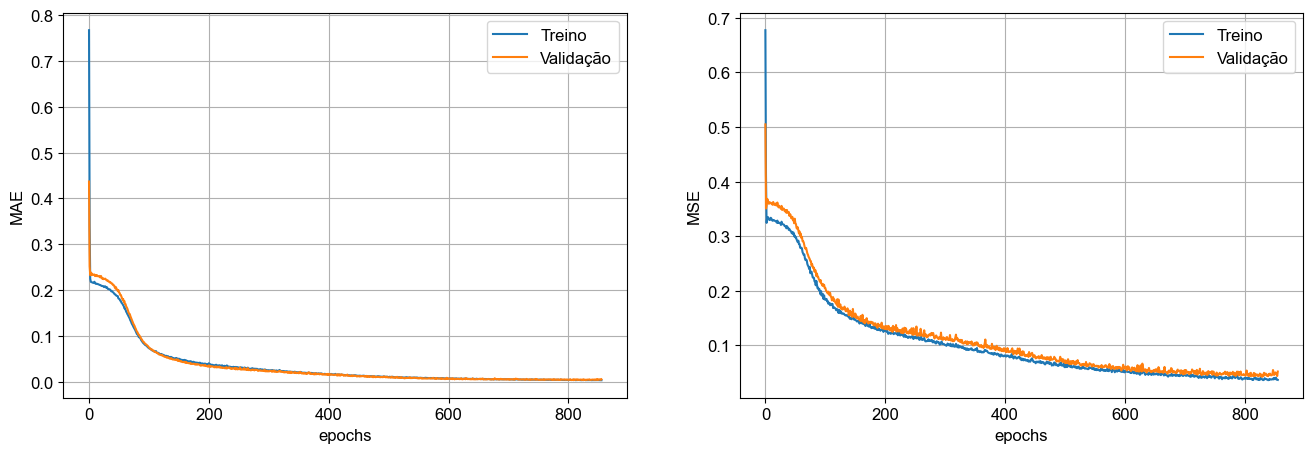

In [287]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs = 1000, 
                    validation_data = (x_val, y_val),
                    callbacks=[early_stop],
                    batch_size=32, verbose=2)

h = history_treatment(history)


In [288]:
yp = out_scaler.inverse_transform(model.predict(x_train))
yv = out_scaler.inverse_transform(y_train)

r2         = r2_score(yv, yp)
rmse       = mean_squared_error(yv, yp)
mape       = mean_absolute_percentage_error(yv.flatten(), yp.flatten())*100

print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

21/21 [==============================] - 0s 766us/step
R² = 0.996 // RMSE = 0.003 // MAPE = 15.065%


In [292]:
yp = np.exp(out_scaler.inverse_transform(model.predict(x_test)))
yv = np.exp(out_scaler.inverse_transform(y_test))

r2         = r2_score(yv, yp)
rmse       = mean_squared_error(yv, yp)
mape       = mean_absolute_percentage_error(yv.flatten(), yp.flatten())*100

print(f'R² = {r2.round(3)} // RMSE = {rmse.round(3)} // MAPE = {mape.round(3)}%')

5/5 [==============================] - 0s 1ms/step


R² = 0.993 // RMSE = 0.025 // MAPE = 3.599%


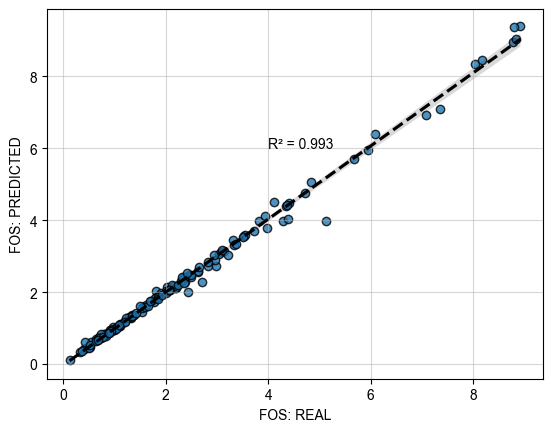

In [295]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
sns.regplot(x = yv,
            y = yp,
            scatter_kws={'edgecolor':'k'}, line_kws={'linestyle':'--', 'color':'k'})

plt.xlabel('FOS: REAL')
plt.ylabel('FOS: PREDICTED')
plt.text(4, 6, f'R² = {r2.round(3)}')
plt.grid(alpha = 0.5)

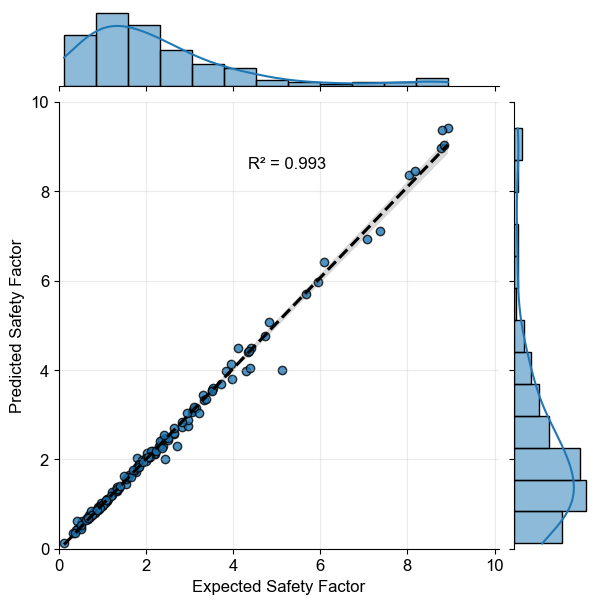

In [298]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
sns.jointplot(x = yv.flatten(),
              y = yp.flatten(),
              kind='reg', 
              scatter_kws={'edgecolor':'k'}, line_kws={'linestyle':'--', 'color':'k'}
              )

plt.xlabel('Expected Safety Factor')
plt.ylabel('Predicted Safety Factor')
plt.xlim([0,10.1])
plt.ylim([0,10])
plt.text(4.35, 8.5, f'R² = {r2.round(3)}')
plt.grid(alpha = 0.25)

In [299]:
error = [100*abs((yv.flatten()[i] - yp.flatten()[i]) / (yp.flatten()[i])) for i in range(yp.shape[0])]
error = sorted(error)
error_95 = error[:int(len(error) * .95)]
error_90 = error[:int(len(error) * .90)]


n_high_10 = np.where(np.array([error]) > 10)[1].shape[0]
n_high_5  = np.where(np.array([error]) > 5)[1].shape[0]
id_high_5 = list(np.where(np.array([error]) > 5)[1])
id_high_10 = list(np.where(np.array([error]) > 10)[1])

max_error = np.round(max(error),3)
less_10_error = np.round(n_high_10*100/len(error), 3)
less_5_error = np.round(n_high_5*100/len(error),3)
print(f' Maximun error: {max_error}%')
print(f' {less_10_error}% are higher than 10%')
print(f' {less_5_error}% are higher than 5%')


 Maximun error: 31.798%
 5.594% are higher than 10%
 18.182% are higher than 5%


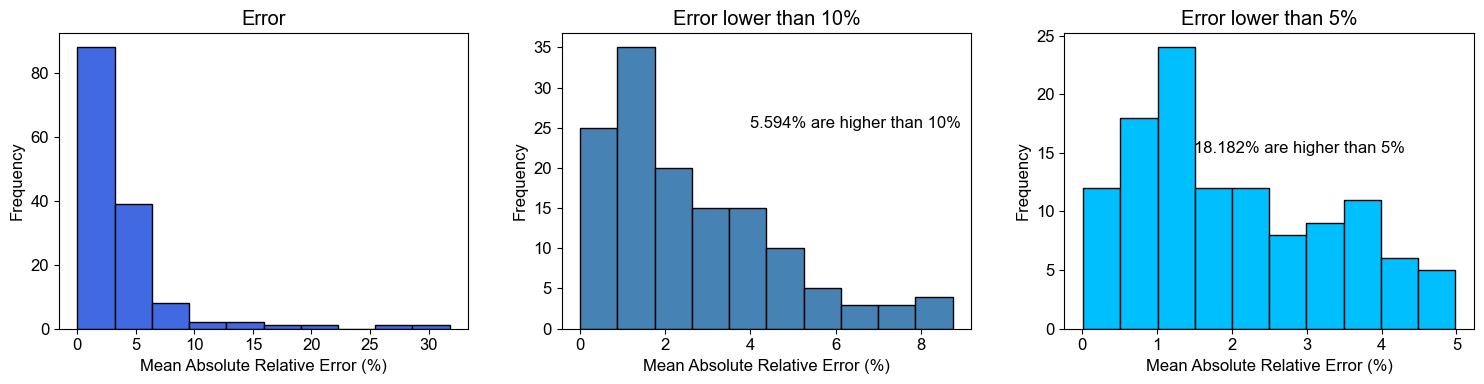

In [300]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(4)

# ax[0].grid(alpha = 0.3)
# ax[1].grid(alpha = 0.3)
# ax[2].grid(alpha = 0.3)

ax[0].hist(error, bins = 10, edgecolor = 'k', color = 'royalblue')
ax[1].hist([e for e in error if e<10], bins = 10, edgecolor = 'k', color = 'steelblue')
ax[2].hist([e for e in error if e<5], bins = 10, edgecolor = 'k', color = 'deepskyblue')

ax[0].set_title('Error')
ax[1].set_title('Error lower than 10%')
ax[2].set_title('Error lower than 5%')

ax[1].text(x = 4, y = 25, s= f'{less_10_error}% are higher than 10%')   
ax[2].text(x = 1.5, y = 15, s= f'{less_5_error}% are higher than 5%')

ax[0].set_xlabel('Mean Absolute Relative Error (%)')
ax[1].set_xlabel('Mean Absolute Relative Error (%)')
ax[2].set_xlabel('Mean Absolute Relative Error (%)')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[2].set_ylabel('Frequency')
plt.tight_layout()

In [303]:
from sklearn.inspection import permutation_importance


# Calculate the feature importance scores
results = permutation_importance(model, x_val, y_val, n_repeats=100,
                                 scoring='neg_mean_absolute_percentage_error', random_state=42)
importance = results.importances_mean

# Print the feature importance scores
for i,v in enumerate(importance):
    print('Feature %d: %.5f' % (i,v))

5/5 [==============================] - 0s 1ms/step
Feature 0: 4.33817
Feature 1: 4.53639
Feature 2: 3.74335
Feature 3: 5.84574
Feature 4: 1.68429


'\nWhen features are collinear, permuting one feature has little effect on the models performance\nbecause it can get the same information from a correlated feature. Note that this is not the \ncase for all predictive models and depends on their underlying implementation.\n\nTHIS PROBABLY IS THE CASE OF Hw and H\n'

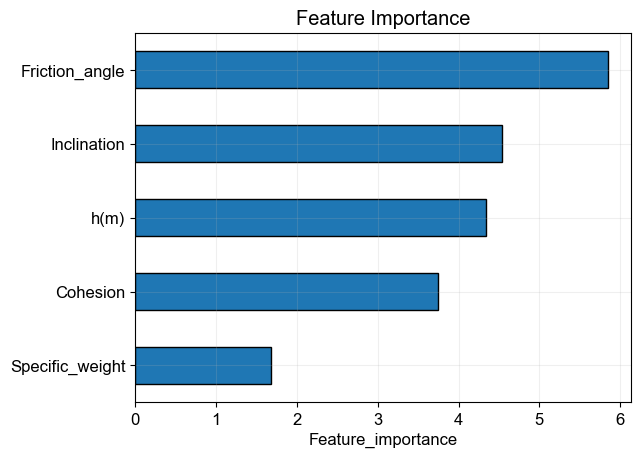

In [305]:
"""
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
"""
df_importance = pd.DataFrame(importance).T
df_importance.columns = inp_columns
dff = df_importance.T.sort_values(0, axis=0)
dff
dff.plot(kind='barh', edgecolor = 'k', legend=False, title='Feature Importance')
plt.grid(alpha = 0.2)
plt.xlabel('Feature_importance')
'''
When features are collinear, permuting one feature has little effect on the models performance
because it can get the same information from a correlated feature. Note that this is not the 
case for all predictive models and depends on their underlying implementation.

THIS PROBABLY IS THE CASE OF Hw and H
'''
